In [38]:
%load_ext autoreload
%autoreload 2

import glob
from fibsem.segmentation.model import SegmentationModel
import tifffile as tf
import matplotlib.pyplot as plt


from random import shuffle

import numpy as np
from fibsem.detection.utils import Feature, FeatureType, DetectionResult
from autoscript_sdb_microscope_client.structures import AdornedImage

from fibsem.structures import Point
from fibsem.imaging import masks
from fibsem.detection import detection
import skimage

from pathlib import Path
from dataclasses import dataclass

from fibsem import conversions


from pprint import pprint


from fibsem.segmentation.model import load_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Detection Goals


1. Detect Needle Tip
2. Detect Lamella Centre
3. Detect Lamella Edges (Right / Left, Up / Down)

account for multiple lamellas
mask centre?

250


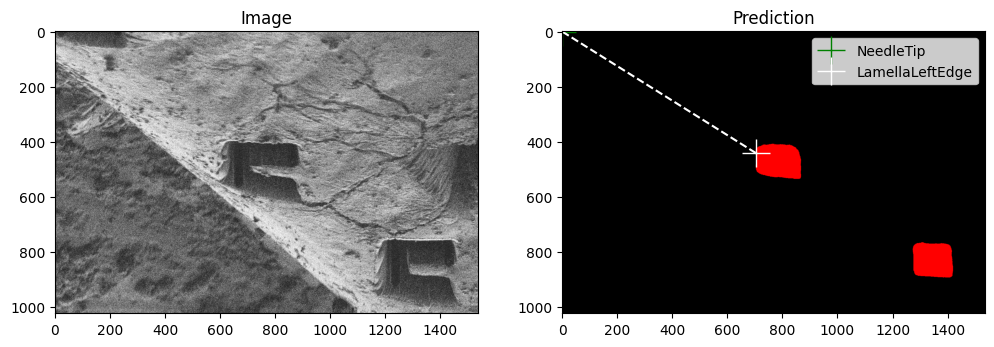

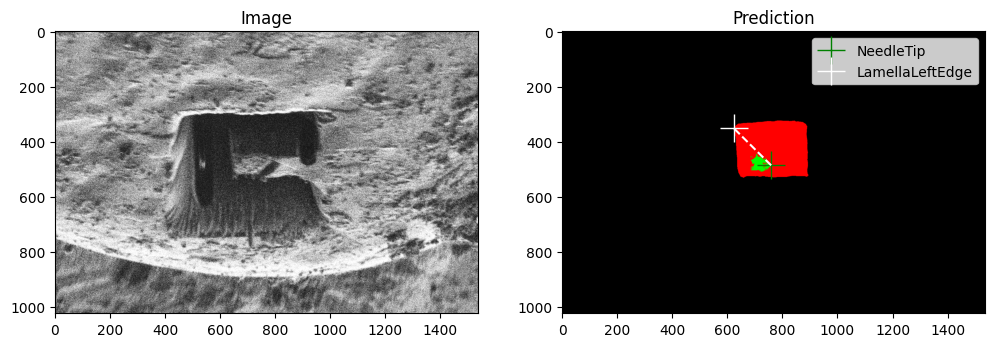

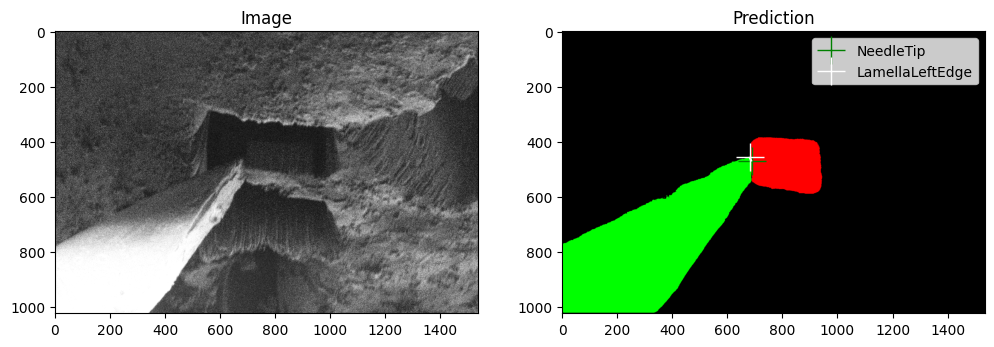

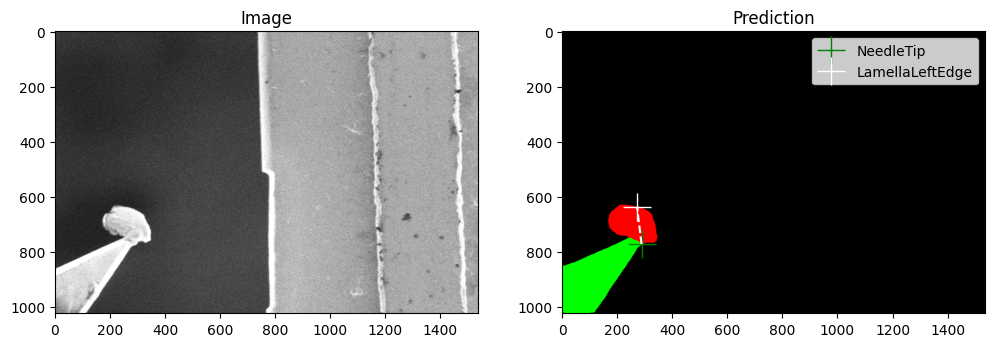

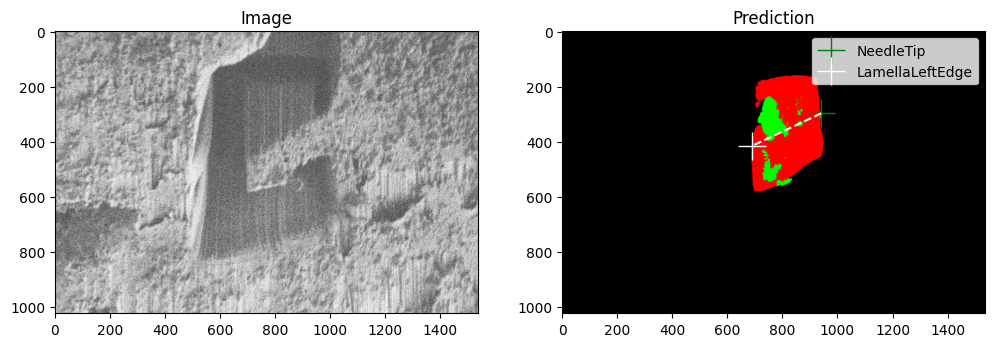

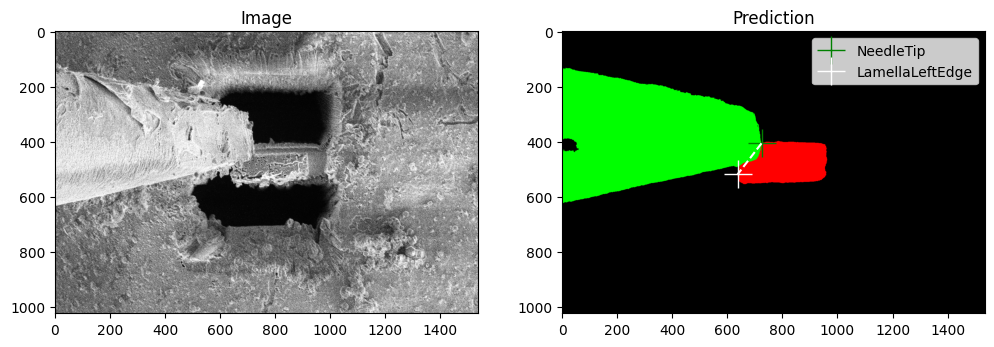

In [43]:


# data



filenames = glob.glob("/home/patrick/github/data/training/images/*.tif")
print(len(filenames))

# model
checkpoint = "/home/patrick/github/fibsem/fibsem/segmentation/models/model.pt"
model = load_model(checkpoint)





def to_bounding_box(contour):
    # convert a contour to bounding box (xc, yc, w, h)
    # ref : https://muthu.co/draw-bounding-box-around-contours-skimage/

    xmin, xmax = np.min(contour[:, 1]), np.max(contour[:, 1])
    ymin, ymax = np.min(contour[:, 0]), np.max(contour[:, 0])

    w = (xmax - xmin)
    h = (ymax - ymin)
    xc = xmin + w // 2
    yc = ymin + h // 2
    
    return [xc, yc, w, h]
    




# THINGS TO TRY:
# masking centre area for lamella
# using contours to extract individual lamellas -> pick centre


shuffle(filenames)
for i, fname in enumerate(filenames):

    img = tf.imread(fname)

    # inference
    mask = model.inference(img)


    # detect features
    features = [Feature(FeatureType.NeedleTip), 
                    Feature(FeatureType.LamellaLeftEdge)]
    det = detection.locate_shift_between_features_v2(img, model, features=features, pixelsize=10e-9)

    # plot
    plot_det_result_v2(det)


    if i == 5:
        break


In [ ]:


# mask helper


# centre circle
# left/right half
# top/bottom half


from fibsem.imaging import masks
import numpy as np


arr = np.zeros(shape=(720, 1200 ))

circ_mask = masks.create_circle_mask(arr.shape, radius=128)


bl_mask = masks.get_area_mask(arr, left=True, lower=True)
ul_mask = masks.get_area_mask(arr, left=True, upper=True)
br_mask = masks.get_area_mask(arr, left=True, lower=True)
ur_mask = masks.get_area_mask(arr, right=True, upper=True)
mask = masks.get_area_mask(arr, left=True)


fig, ax = plt.subplots(1, 5, figsize=(15, 7))
ax[0].imshow(bl_mask)
ax[1].imshow(ul_mask)
ax[2].imshow(br_mask)
ax[3].imshow(ur_mask)
ax[4].imshow(mask)
plt.show()



In [ ]:
# contour stuff
    # options for getting individual lamella from multiple: contours, masking 
    # bboxes = []
    # contours = skimage.measure.find_contours(lamella_mask[:, :, 0].astype(np.uint8), 0.8)
    # for contour in contours:
    #     bboxes.append(to_bounding_box(contour))
        # for contour in contours:
    #     ax[1].plot(contour[:, 1], contour[:, 0], color="white", linewidth=1)
    